In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# ✅ Check if GPU is available
print("🔍 Available GPUs:", tf.config.list_physical_devices('GPU'))


# Load processed sequences
user_sequences = pd.read_csv("lstm_input_cleaned3.csv")

# Convert string activity sequences to lists
user_sequences['activity_encoded'] = user_sequences['activity_encoded'].apply(eval)

# Define max sequence length
MAX_SEQ_LENGTH = 74  
# Pad sequences
X = pad_sequences(user_sequences['activity_encoded'], maxlen=MAX_SEQ_LENGTH, padding='post')

# Get labels
y = user_sequences['anomalous'].values  

# Train-test split (Stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"✅ Data Loaded! Train shape: {X_train.shape}, Test shape: {X_test.shape}")

🔍 Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ Data Loaded! Train shape: (108783, 74), Test shape: (27196, 74)


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, RepeatVector, TimeDistributed, Dense


# ✅ LSTM Autoencoder with CuDNN Optimizations
model = Sequential([
    # Encoder
    LSTM(128, input_shape=(MAX_SEQ_LENGTH, 1), return_sequences=True, activation="tanh", recurrent_activation="sigmoid"),
    Dropout(0.3),
    LSTM(64, return_sequences=False, activation="tanh", recurrent_activation="sigmoid"),
    Dropout(0.3),

    # Latent Representation
    RepeatVector(MAX_SEQ_LENGTH),

    # Decoder
    LSTM(64, return_sequences=True, activation="tanh", recurrent_activation="sigmoid"),
    Dropout(0.3),
    LSTM(128, return_sequences=True, activation="tanh", recurrent_activation="sigmoid"),
    TimeDistributed(Dense(1))
])


from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mse')

print("✅ Model built with CuDNN LSTM optimization!")
model.summary()


✅ Model built with CuDNN LSTM optimization!
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 74, 128)           66560     
                                                                 
 dropout_9 (Dropout)         (None, 74, 128)           0         
                                                                 
 lstm_15 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 repeat_vector_4 (RepeatVect  (None, 74, 64)           0         
 or)                                                             
                                                                 
 lstm_16 (LSTM)              (None, 74, 64)            33024     
          

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ✅ Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ✅ Save the best model
model_checkpoint = ModelCheckpoint("best_lstm_autoencoder2.h5", monitor="val_loss", save_best_only=True, verbose=1)

# ✅ Reshape input for LSTM
X_train_auto = X_train[y_train == 0].reshape((-1, MAX_SEQ_LENGTH, 1))
X_test = X_test.reshape((-1, MAX_SEQ_LENGTH, 1))

# ✅ Train with GPU acceleration
history = model.fit(
    X_train_auto, X_train_auto, 
    epochs=50, batch_size=32, 
    validation_data=(X_test, X_test),
    callbacks=[early_stopping, model_checkpoint],
    verbose=2
)

print("🚀 Training Complete! Best model saved as 'best_lstm_autoencoder.h5'")



Epoch 1/50

Epoch 1: val_loss improved from inf to 279.98245, saving model to best_lstm_autoencoder2.h5
3375/3375 - 133s - loss: 392.8171 - val_loss: 279.9825 - 133s/epoch - 39ms/step
Epoch 2/50

Epoch 2: val_loss improved from 279.98245 to 87.94490, saving model to best_lstm_autoencoder2.h5
3375/3375 - 127s - loss: 154.6272 - val_loss: 87.9449 - 127s/epoch - 38ms/step
Epoch 3/50

Epoch 3: val_loss improved from 87.94490 to 65.34955, saving model to best_lstm_autoencoder2.h5
3375/3375 - 130s - loss: 76.9071 - val_loss: 65.3495 - 130s/epoch - 39ms/step
Epoch 4/50

Epoch 4: val_loss improved from 65.34955 to 43.24813, saving model to best_lstm_autoencoder2.h5
3375/3375 - 129s - loss: 59.0021 - val_loss: 43.2481 - 129s/epoch - 38ms/step
Epoch 5/50

Epoch 5: val_loss improved from 43.24813 to 28.29413, saving model to best_lstm_autoencoder2.h5
3375/3375 - 130s - loss: 41.7071 - val_loss: 28.2941 - 130s/epoch - 39ms/step
Epoch 6/50

Epoch 6: val_loss improved from 28.29413 to 25.69808, savi

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Predict on test data
X_test_pred = model.predict(X_test)

# Compute reconstruction error (Mean Absolute Error)
reconstruction_errors = np.mean(np.abs(X_test - X_test_pred), axis=(1, 2))

# Save reconstruction errors
np.save("reconstruction_errors.npy", reconstruction_errors)

print("✅ Reconstruction errors computed & saved!")


850/850 [==============================] - 14s 15ms/step
✅ Reconstruction errors computed & saved!


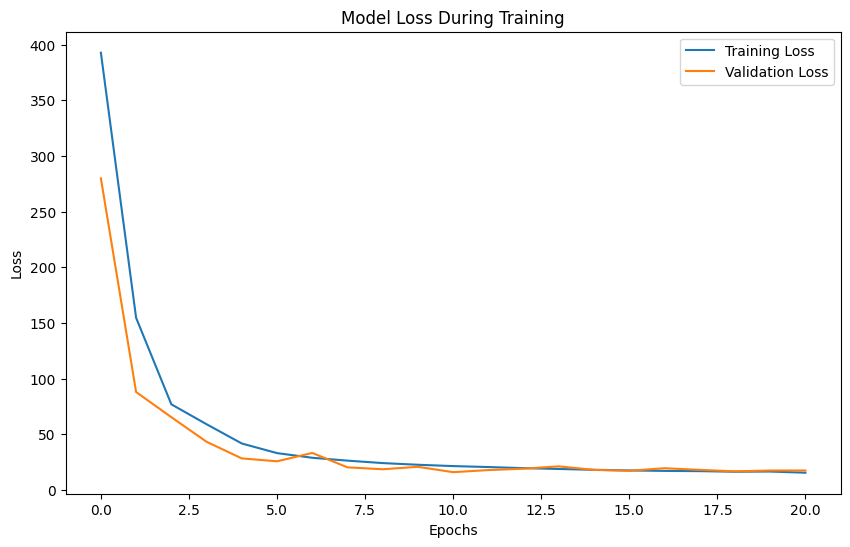

In [29]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


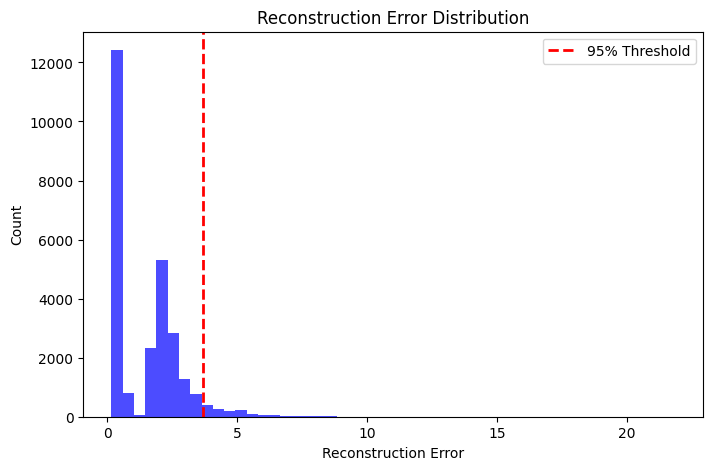

In [30]:
plt.figure(figsize=(8, 5))
plt.hist(reconstruction_errors, bins=50, color='blue', alpha=0.7)
plt.axvline(np.percentile(reconstruction_errors, 95), color='red', linestyle='dashed', linewidth=2, label="95% Threshold")
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.title("Reconstruction Error Distribution")
plt.legend()
plt.show()


In [31]:
# ✅ Set threshold at the 95th percentile of reconstruction errors
threshold = np.percentile(reconstruction_errors, 95)

# ✅ Predict anomalies based on threshold
y_pred = (reconstruction_errors > threshold).astype(int)  # 1 = anomalous, 0 = normal

# ✅ Save anomaly predictions
np.save("anomaly_predictions.npy", y_pred)

print(f"🚨 Anomaly threshold set at: {threshold:.4f}")


🚨 Anomaly threshold set at: 3.6899


In [32]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix, roc_curve, auc

# ✅ Compute Precision, Recall, F1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")

# ✅ Compute AUC-ROC Score
auc_roc = roc_auc_score(y_test, reconstruction_errors)

print(f"🔹 Precision: {precision:.4f}")
print(f"🔹 Recall: {recall:.4f}")
print(f"🔹 F1-score: {f1:.4f}")
print(f"🔹 AUC-ROC: {auc_roc:.4f}")


🔹 Precision: 0.0331
🔹 Recall: 0.2284
🔹 F1-score: 0.0578
🔹 AUC-ROC: 0.7238


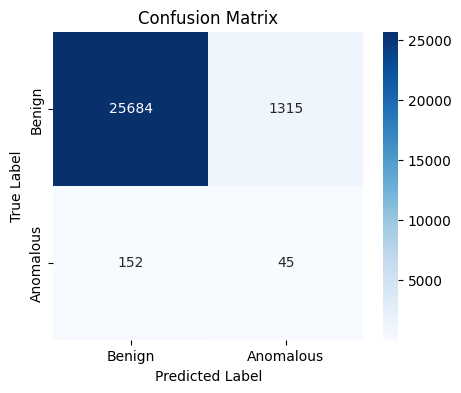

In [33]:
import seaborn as sns
import pandas as pd

# ✅ Compute Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# ✅ Plot Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Anomalous"], yticklabels=["Benign", "Anomalous"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


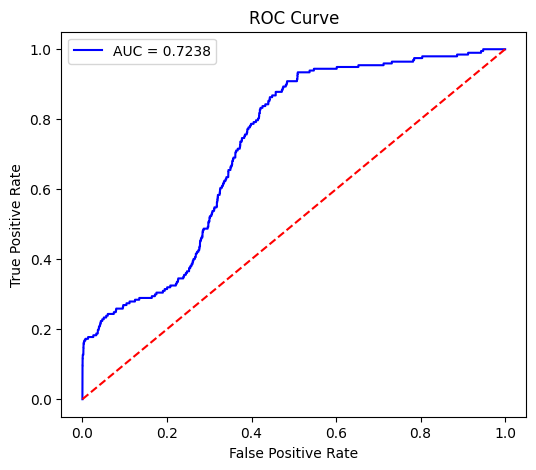

In [34]:
# ✅ Compute ROC Curve
fpr, tpr, _ = roc_curve(y_test, reconstruction_errors)
roc_auc = auc(fpr, tpr)

# ✅ Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [35]:
import numpy as np

# ✅ Get model predictions (reconstructed sequences)
X_test_pred = model.predict(X_test)

# ✅ Compute reconstruction errors (Mean Absolute Error per sequence)
reconstruction_errors = np.mean(np.abs(X_test - X_test_pred), axis=(1, 2))

# ✅ Set anomaly detection threshold (Top 5% of errors)
threshold = np.percentile(reconstruction_errors, 90)

# ✅ Predict anomalies based on threshold
y_pred = (reconstruction_errors > threshold).astype(int)  # 1 = anomalous, 0 = benign

print(f"🚨 Anomaly threshold set at: {threshold:.4f}")


850/850 [==============================] - 13s 15ms/step
🚨 Anomaly threshold set at: 2.9923


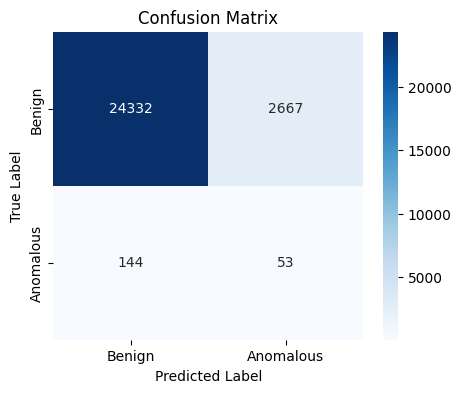

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Compute Confusion Matrix based on Model Predictions
cm = confusion_matrix(y_test, y_pred)

# ✅ Plot Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Anomalous"], yticklabels=["Benign", "Anomalous"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [37]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

# ✅ Compute Precision, Recall, F1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")

# ✅ Compute AUC-ROC Score
auc_roc = roc_auc_score(y_test, reconstruction_errors)

print(f"🔹 Precision: {precision:.4f}")
print(f"🔹 Recall: {recall:.4f}")
print(f"🔹 F1-score: {f1:.4f}")
print(f"🔹 AUC-ROC: {auc_roc:.4f}")


🔹 Precision: 0.0195
🔹 Recall: 0.2690
🔹 F1-score: 0.0363
🔹 AUC-ROC: 0.7238
